# Facility Location Notebook Example

This example demonstrates how the Lingo/Python API can be integrated into Jupyter Notebook.
The two Lingo models are written in cells using the magic function `%%writefile facilityLocation.lng`. When the cell containing the Lingo model is ran the file `facilityLocation.lng` is over written and saved in the same directory of the notebook. Running the bellow cell with `%pip` will download any of the libraries included in the notebook that are not yet installed. It is best to run each cell from top to bottom to avoid running a cell data not yet defined. 

Requiered Kernel python 3.7 - 3.10 to upgrade or change kernel version see [IPython Doc](https://ipython.readthedocs.io/en/stable/install/kernel_install.html).


In [ ]:
%pip install lingo_api
%pip install matplotlib
%pip install pandas

In [1]:
import lingo_api as lingo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Defines uData and an error callback function for each model to call
# This will rasie an exception if there are any errors from Lingo
uData = {}
def cbError(pEnv, uData, nErrorCode, errorText):
    raise lingo.CallBackError(nErrorCode, errorText)

The first model finds a location for a wherehouse $x \in \mathbf{R}^2$ with the minimum maximum eucliden distance to any given point $y_i \in \mathbf{R}^2$.

$$
\min_x \max_{i = 1, \dots, m}\|x - y_i\|_2
$$

This problem can be restated as a second-oreder cone problem.
$$
\min_{x,t} t
$$
$$
st \quad \|x - y_i\| \leq t  \quad i \in 1:m
$$

Where $t \in \mathbf{R}$ is the minimum maximum eucliden distance.

In [19]:
%%writefile facilityLocation.lng
MODEL:
    
DATA:
MPOINTS = @POINTER(1);  
ENDDATA

SETS:
POINTS/1 .. MPOINTS/:PROD;
COORDINATE/1 .. 2/;

LOCATIONS(COORDINATE,POINTS):Y;
FACILITY/1/: T;
FACILITYLOC(COORDINATE, FACILITY): X;
ENDSETS

DATA:
Y = @POINTER(2);
ENDDATA

MIN = T(1);

@FOR(POINTS(I):
    PROD(I) = (X(1,1) - Y(1,I))^2 + (X(2,1) - Y(2,I))^2;
    PROD(I) <= T(1)^2;
);

@FREE(X(1,1));
@FREE(X(2,1));
@FREE(T(1));

DATA:  
@POINTER(3) = X;
@POINTER(4) = T;
@POINTER(5) = @STATUS(); 
ENDDATA

END

Overwriting facilityLocation.lng


In [20]:
# Try the first model on some sample data
lngFile = "facilityLocation.lng"

Y = np.array([[0, 0.2, 0.25, 0.45, 0.6, 0.7, 0.79, 0.94, 1],
              [0.7, 0.96, 0.1, 0.65, 0.48, 0.62, 0.1, 0.5, 0.9]])
MPOINTS = np.shape(Y)[1]
X1 = np.zeros(2)
T1 = np.zeros(1)
STATUS = np.array([-1.0])

model = lingo.Model(lngFile)

model.set_pointer("Pointer1",MPOINTS,lingo.PARAM)
model.set_pointer("Pointer2",Y,lingo.PARAM)
model.set_pointer("Pointer3",X1,lingo.VAR)
model.set_pointer("Pointer4",T1,lingo.VAR)
model.set_pointer("Pointer5",STATUS,lingo.VAR)

# set the call back function and user data
model.set_cbError(cbError)
model.set_uData(uData)

# now that everything is set call solve(model)
lingo.solve(model)

0

In [21]:
# Compute some data with the model output 
X1 = X1.reshape(2,1)
distance1 = np.sqrt(np.sum((X1-Y)**2, axis=0))
avgDistance1 = np.average(distance1)
print("Minimum Max Distance (Model #1)")
print(f" Location 1       : ({X1[0][0]:.4f}, {X1[1][0]:.4f})")
print(f" Max Distance     : {T1[0]:.4f}")
print(f" Average Distance : {avgDistance1:.4f}\n")

Minimum Max Distance (Model #1)
 Location 1       : (0.5450, 0.5750)
 Max Distance     : 0.5592
 Average Distance : 0.3915



Another opproch to locating a wherehouse could be minimizing the average distace to the wherehose $x \in \mathbf{R}^2$ from any given point $y_i \in \mathbf{R}^2$.

$$
\min_x \frac{1}{m}\sum_{i = 1}^m\|x - y_i\|_2
$$

Like the first model this one can also be rewritten as a second-oreder cone problem.

$$
\min_{x,t} \frac{1}{m}\sum_{i=1}^m t_i
$$
$$
st \quad \|x - y_i\| \leq t_i  \quad i \in 1:m
$$

In [23]:
%%writefile facilityLocationAVG.lng
MODEL:
    
DATA:
MPOINTS = @POINTER(1);  
ENDDATA

SETS:
POINTS/1 .. MPOINTS/: T, PROD;
COORDINATE/1 .. 2/;

LOCATIONS(COORDINATE,POINTS):Y;
FACILITY/1/;
FACILITYLOC(COORDINATE, FACILITY): X;
ENDSETS

DATA:
Y = @POINTER(2);
ENDDATA

MIN = 1/MPOINTS * @SUM(POINTS(I): T(I));

@FOR(POINTS(I):
    PROD(I) = (X(1,1) - Y(1,I))^2 + (X(2,1) - Y(2,I))^2;
    PROD(I) <= T(I)^2;
);

@FREE(X(1,1));
@FREE(X(2,1));
@FOR(POINTS(I): @FREE(T(I)));

DATA:  
@POINTER(3) = X;
@POINTER(4) = T;
@POINTER(5) = @STATUS(); 
ENDDATA

END

Overwriting facilityLocationAVG.lng


In [24]:
lngFile = "facilityLocationAVG.lng"

Y = np.array([[0, 0.2, 0.25, 0.45, 0.6, 0.7, 0.79, 0.94, 1],[0.7, 0.96, 0.1, 0.65, 0.48, 0.62, 0.1, 0.5, 0.9]])
MPOINTS = np.shape(Y)[1]
X2 = np.zeros(2)
T2 = np.zeros(MPOINTS)
STATUS = np.array([-1.0])

model = lingo.Model(lngFile)

model.set_pointer("Pointer1",MPOINTS,lingo.PARAM)
model.set_pointer("Pointer2",Y,lingo.PARAM)
model.set_pointer("Pointer3",X2,lingo.VAR)
model.set_pointer("Pointer4",T2,lingo.VAR)
model.set_pointer("Pointer5",STATUS,lingo.VAR)

# set the call back function and user data
model.set_cbError(cbError)
model.set_uData(uData)

# now that everything is set call solve(model)
lingo.solve(model)

0

In [25]:
X2 = X2.reshape(2,1)
distance2 = np.sqrt(np.sum((X2-Y)**2, axis=0))
avgDistance2 = np.average(distance2)
maxDistance2 = np.max(distance2)
avgT2 = np.average(T2)

In [26]:
print("Minimum Max Distance (Model #1)")
print(f" Location 1       : ({X1[0][0]:.4f}, {X1[1][0]:.4f})")
print(f" Max Distance     : {T1[0]:.4f}")
print(f" Average Distance : {avgDistance1:.4f}\n")

print("Minimum Average Distance (Model #1)")
print(f" Location 2       : ({X2[0][0]:.4f}, {X2[1][0]:.4f})")
print(f" Max Distance     : {maxDistance2:.4f}")
print(f" Average Distance : {avgT2:.4f}\n")

print(" Location     Distance 1  Distance 2")
for i in range(MPOINTS):
    print(f"({Y[0][i]:.2f},{Y[1][i]:.2f})      {distance1[i]:.2f}       {distance2[i]:.2f}")

Minimum Max Distance (Model #1)
 Location 1       : (0.5450, 0.5750)
 Max Distance     : 0.5592
 Average Distance : 0.3915

Minimum Average Distance (Model #1)
 Location 2       : (0.5933, 0.5433)
 Max Distance     : 0.6136
 Average Distance : 0.3885

 Location     Distance 1  Distance 2
(0.00,0.70)      0.56       0.61
(0.20,0.96)      0.52       0.57
(0.25,0.10)      0.56       0.56
(0.45,0.65)      0.12       0.18
(0.60,0.48)      0.11       0.06
(0.70,0.62)      0.16       0.13
(0.79,0.10)      0.53       0.48
(0.94,0.50)      0.40       0.35
(1.00,0.90)      0.56       0.54


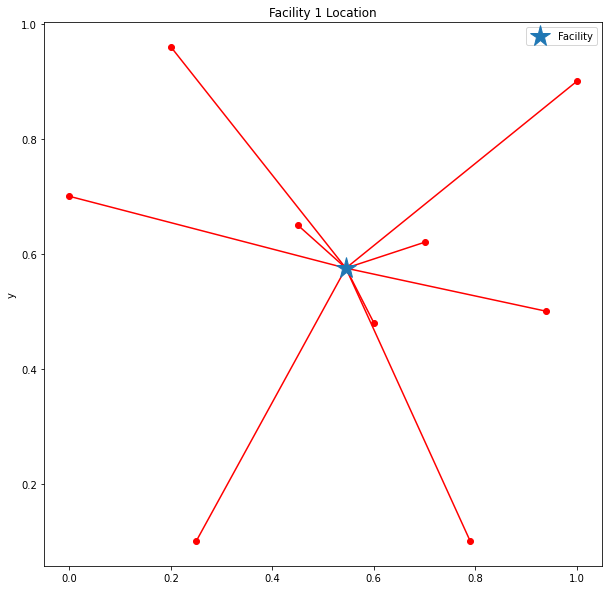

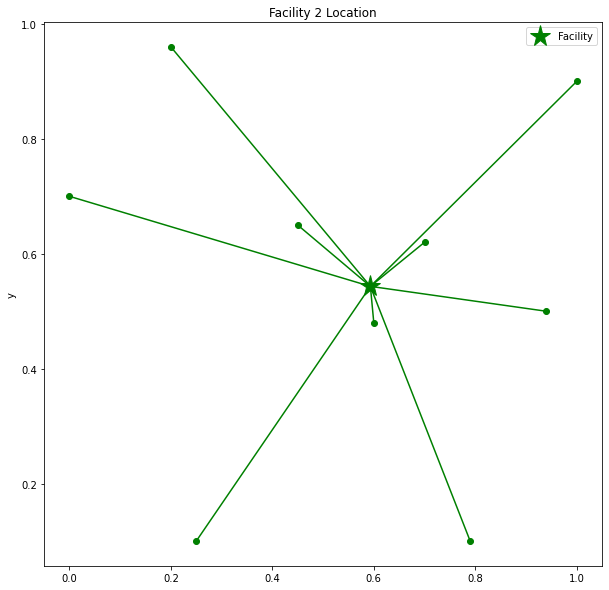

In [27]:
fig1 , axModel1 = plt.subplots(figsize=(10, 10))

axModel1.set_title('x')
axModel1.set_ylabel('y')
axModel1.set_title('Facility 1 Location')
for i in range(MPOINTS):
   axModel1.plot([Y[0][i],X1[0][0]], [Y[1][i], X1[1][0]], '-ro')

axModel1.plot(X1[0],X1[1], '*', label='Facility',markersize=22)
axModel1.legend()

fig2 , axModel2 = plt.subplots(figsize=(10, 10))

axModel2.set_title('x')
axModel2.set_ylabel('y')
axModel2.set_title('Facility 2 Location')
for i in range(MPOINTS):
   axModel2.plot([Y[0][i],X2[0][0]], [Y[1][i], X2[1][0]], '-go')

axModel2.plot(X2[0],X2[1], 'g*', label='Facility', markersize=22)
axModel2.legend()

Next try the two models out on a bigger data set of neighborhoods in the city of Huston Texas.
This data set was found on [Kaggle](https://www.kaggle.com/datasets/mrchristolpher/houston-texas-neighborhoods-lat-long-list), and is located in the same file as the notebook. First read in the csv with pandas, and then prepare the data so that it fits in the model. This requires transposing the Latitude and Longitude columns after they are assignd to the np array `Y_Huston`. Once the data is prepared and passed to the Lingo models then lets look at the results like we did with the fake data.

In [28]:
df = pd.read_csv("Houston_Texas_Neighborhoods_Lat_Long_List - Sheet1.csv")
df

,Neighborhood,City,State,Latitude,Longitude,Full Address
0,Acres Home,Houston,Texas,29.870719,-95.436543,"Acres Home, Houston, Texas"
1,Addicks,Houston,Texas,29.813269,-95.645476,"Addicks, Houston, Texas"
2,Afton Oaks,Houston,Texas,29.736854,-95.453248,"Afton Oaks, Houston, Texas"
3,Alief,Houston,Texas,29.682720,-95.593239,"Alief, Houston, Texas"
4,Astrodome Area,Houston,Texas,29.685208,-95.403226,"Astrodome Area, Houston, Texas"
...,...,...,...,...,...,...
83,Westbury,Houston,Texas,29.653609,-95.480413,"Westbury, Houston, Texas"
84,Westchase,Houston,Texas,29.727756,-95.571662,"Westchase, Houston, Texas"
85,Westwood,Houston,Texas,29.675326,-95.550221,"Westwood, Houston, Texas"
86,Willow Meadows,Houston,Texas,29.673300,-95.439883,"Willow Meadows, Houston, Texas"


In [29]:
# Shared data
Y_Huston = np.transpose(df.iloc[:,3:5].values)
MPOINTS = np.shape(Y_Huston)[1]

lngFile1 = "facilityLocation.lng"


X_Huston1 = np.zeros(2)
T_Huston1 = np.zeros(1)
STATUS = np.array([-1.0])

model = lingo.Model(lngFile1)

model.set_pointer("Pointer1",MPOINTS,lingo.PARAM)
model.set_pointer("Pointer2",Y_Huston,lingo.PARAM)
model.set_pointer("Pointer3",X_Huston1,lingo.VAR)
model.set_pointer("Pointer4",T_Huston1,lingo.VAR)
model.set_pointer("Pointer5",STATUS,lingo.VAR)

# set the call back function and user data
model.set_cbError(cbError)
model.set_uData(uData)

# now that everything is set call solve(model)
lingo.solve(model)


lngFile2 = "facilityLocationAVG.lng"


X_Huston2 = np.zeros(2)
T_Huston2 = np.zeros(MPOINTS)
STATUS = np.array([-1.0])

model = lingo.Model(lngFile2)

model.set_pointer("Pointer1",MPOINTS,lingo.PARAM)
model.set_pointer("Pointer2",Y_Huston,lingo.PARAM)
model.set_pointer("Pointer3",X_Huston2,lingo.VAR)
model.set_pointer("Pointer4",T_Huston2,lingo.VAR)
model.set_pointer("Pointer5",STATUS,lingo.VAR)

# set the call back function and user data
model.set_cbError(cbError)
model.set_uData(uData)

# now that everything is set call solve(model)
lingo.solve(model)

0

In [30]:
X_Huston1 = X_Huston1.reshape(2,1)
distance1 = np.sqrt(np.sum((X_Huston1-Y_Huston)**2, axis=0))
avgDistance1 = np.average(distance1)

X_Huston2 = X_Huston2.reshape(2,1)
distance2 = np.sqrt(np.sum((X_Huston2-Y_Huston)**2, axis=0))
avgDistance2 = np.average(distance2)
maxDistance2 = np.max(distance2)
avgT2 = np.average(T2)

In [31]:
print("Minimum Max Distance (Model #1)")
print(f" Location 1       : ({X_Huston1[0][0]:.4f}, {X_Huston1[1][0]:.4f})")
print(f" Max Distance     : {T1[0]:.4f}")
print(f" Average Distance : {avgDistance1:.4f}\n")

print("Minimum Average Distance (Model #1)")
print(f" Location 2       : ({X_Huston2[0][0]:.4f}, {X_Huston2[1][0]:.4f})")
print(f" Max Distance     : {maxDistance2:.4f}")
print(f" Average Distance : {avgT2:.4f}\n")

print(" Location                        Distance 1 Distance 2")
for i in range(MPOINTS):
    print(f"{df.Neighborhood[i]:30}      {distance1[i]:.2f}       {distance2[i]:.2f}")

Minimum Max Distance (Model #1)
 Location 1       : (29.7823, -95.4785)
 Max Distance     : 0.5592
 Average Distance : 0.1544

Minimum Average Distance (Model #1)
 Location 2       : (29.7461, -95.3917)
 Max Distance     : 0.4581
 Average Distance : 0.3885

 Location                        Distance 1 Distance 2
Acres Home                          0.10       0.13
Addicks                             0.17       0.26
Afton Oaks                          0.05       0.06
Alief                               0.15       0.21
Astrodome Area                      0.12       0.06
Braeburn                            0.12       0.15
Braeswood                           0.10       0.07
Brays Oaks                          0.14       0.16
Briar Forest                        0.11       0.20
Carverdale                          0.10       0.19
Central Northwest                   0.06       0.10
Central Southwest                   0.16       0.12
Clear Lake                          0.40       0.30
Clinton Par

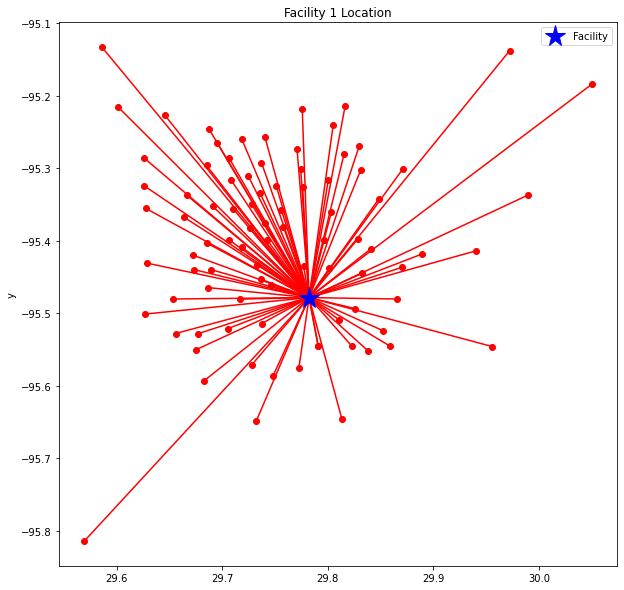

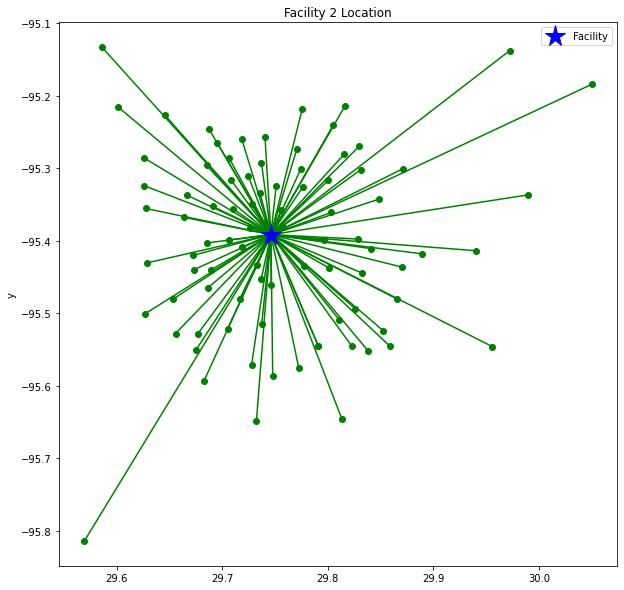

In [32]:
fig1 , axModel1 = plt.subplots(figsize=(10, 10))

axModel1.set_title('x')
axModel1.set_ylabel('y')
axModel1.set_title('Facility 1 Location')
for i in range(MPOINTS):
   axModel1.plot([Y_Huston[0][i],X_Huston1[0][0]], [Y_Huston[1][i], X_Huston1[1][0]], '-ro')

axModel1.plot(X_Huston1[0],X_Huston1[1], 'b*', label='Facility',markersize=22)
axModel1.legend()

fig2 , axModel2 = plt.subplots(figsize=(10, 10))

axModel2.set_title('x')
axModel2.set_ylabel('y')
axModel2.set_title('Facility 2 Location')
for i in range(MPOINTS):
   axModel2.plot([Y_Huston[0][i],X_Huston2[0][0]], [Y_Huston[1][i], X_Huston2[1][0]], '-go')

axModel2.plot(X_Huston2[0],X_Huston2[1], 'b*', label='Facility', markersize=22)
axModel2.legend()